# Simple Reinforcement Learning with Tensorflow: Deep Q-Networks and Beyond

This iPython notebook implements a Deep Q-Network using both Double DQN and Dueling DQN. The agent learn to solve a navigation task in a basic grid world. To learn more, read here: https://medium.com/p/8438a3e2b8df

In [18]:
from __future__ import division
from __future__ import print_function

import gym
import numpy as np
import random
import tensorflow as tf
import tensorflow.contrib.slim as slim
import matplotlib.pyplot as plt
import scipy.misc
import os
%matplotlib inline

### Load the game environment

Feel free to adjust the size of the gridworld. Making it smaller provides an easier task for our DQN agent, while making the world larger increases the challenge.

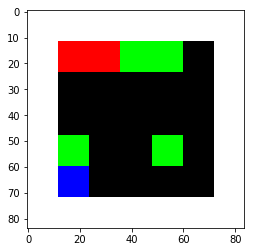

In [24]:
from gridworld import gameEnv

env = gameEnv(partial=False,size=5)
env.reset()
plt.imshow(env.renderEnv())

Above is an example of a starting environment in our simple game. The agent controls the blue square, and can move up, down, left, or right. The goal is to move to the green square (for +1 reward) and avoid the red square (for -1 reward). The position of the three blocks is randomized every episode.

### Implementing the network itself

Remember that:

**Double DQNs**
$$
\underbrace{\mathcal{Q}(s,a)}_{\text{TD target}}=r(s,a) +\underbrace{\gamma \mathcal{Q}\left(s',\underbrace{arg\max_a\mathcal{Q}(s',a)}_{\begin{matrix}\text{DQN chooses action}\\\text{for the next state}\end{matrix}}\right)}_{\begin{matrix}\text{target network calculates the Q-}\\ \text{value of taking that action at state }s\end{matrix}}\tag{1}
$$

**Dueling DQNs**
$$
\mathcal{Q}(s,a;\theta,\alpha,\beta)=V(s;\theta,\beta)+\left[A(s,a;\theta,\alpha)-\underbrace{\frac{1}{\mathcal{A}}\sum_{a'}A(s,a';\theta,\alpha)}_{\text{average advantage}}\right]
\tag{2}$$
where:
- $\theta$ - common network parameters
- $\alpha$ - advantage stream parameters
- $\beta$ - value stream parameters

**DQN architecture:**
![](https://cdn-images-1.medium.com/max/873/1*N_t9I7MeejAoWlDuH1i7cw.png)
Above: Regular DQN with a single stream for Q-values. Below: Dueling DQN where the value and advantage are calculated separately and then combined only at the final layer into a Q value.

In [49]:
class Qnetwork():
    def __init__(self, h_size):
        """
        The network recieves a frame from the game, flattened into an array.
        It then resizes it and processes it through four convolutional layers.
        """
        # Scalar input, from images size 84x84x3
        self.scalarInput =  tf.placeholder(shape=[None,21168], dtype=tf.float32)  # 21168 = 84x84x3
        
        # Conver scalar input to images
        self.imageIn = tf.reshape(self.scalarInput,shape=[-1,84,84,3])
        
        # First convNet
        # In 84x84x3, out 20x20x32
        self.conv1 = \
            slim.conv2d(
                inputs=self.imageIn,
                num_outputs=32,
                kernel_size=[8,8],
                stride=[4,4],
                padding='VALID',
                weights_initializer=tf.contrib.layers.xavier_initializer(),
                biases_initializer=None
        )
        
        # Second convNet
        # In 20x20x32, out 9x9x64
        self.conv2 = \
            slim.conv2d(
                inputs=self.conv1,
                num_outputs=64,
                kernel_size=[4,4],
                stride=[2,2],
                padding='VALID',
                weights_initializer=tf.contrib.layers.xavier_initializer(),
                biases_initializer=None
        )
        
        # Third convNet
        # in 9x9x64, out 7x7x64
        self.conv3 = \
            slim.conv2d(
                inputs=self.conv2,
                num_outputs=64,
                kernel_size=[3,3],
                stride=[1,1],
                padding='VALID', 
                biases_initializer=None
        )
        
        # Fourth convnet
        # in 7x7x64, out 1x1xh_size
        self.conv4 = \
            slim.conv2d(
                inputs=self.conv3,
                num_outputs=h_size,
                kernel_size=[7,7],
                stride=[1,1],
                padding='VALID', 
                biases_initializer=None
        )
        
        # We take the output from the final convolutional layer 
        # and split it into separate advantage and value streams.
        
        self.streamAC, self.streamVC = tf.split(
            value=self.conv4, 
            num_or_size_splits=2,
            axis=3)
        
        # conver to flatten
        self.streamA = slim.flatten(self.streamAC)
        self.streamV = slim.flatten(self.streamVC)
        
        xavier_init = tf.contrib.layers.xavier_initializer()
        self.AW = tf.Variable(xavier_init([h_size//2,env.actions]))
        self.VW = tf.Variable(xavier_init([h_size//2,1]))
        self.Advantage = tf.matmul(self.streamA,self.AW)
        self.Value = tf.matmul(self.streamV,self.VW)
        
        # Then combine them together to get our final Q-values.
        # See the formula (2)
        self.Qout = self.Value + \
                    tf.subtract(
                        self.Advantage,
                        tf.reduce_mean(self.Advantage,axis=1,keep_dims=True)
        )
        self.predict = tf.argmax(self.Qout,1)
        
        # Below we obtain the loss by taking the sum of squares difference 
        # between the target and prediction Q values.
        
        self.targetQ = tf.placeholder(shape=[None],dtype=tf.float32)
        self.actions = tf.placeholder(shape=[None],dtype=tf.int32)
        self.actions_onehot = tf.one_hot(indices=self.actions, depth=env.actions, dtype=tf.float32)
        
        self.Q = tf.reduce_sum(tf.multiply(self.Qout, self.actions_onehot), axis=1)
        
        # Set objective function for training
        self.td_error = tf.square(self.targetQ - self.Q)
        self.loss = tf.reduce_mean(self.td_error)
        self.trainer = tf.train.AdamOptimizer(learning_rate=0.0001)
        self.updateModel = self.trainer.minimize(self.loss)

In [69]:
network.predict

<tf.Tensor 'ArgMax_5:0' shape=(?,) dtype=int64>

In [51]:
network = Qnetwork(16)
print(network)

### Experience Replay

This class allows us to store experies and sample then randomly to train the network.

In [65]:
class experience_buffer():
    """
    This class allows us to store experiences and sample then randomly to train the network.
    experiment = (current state, action, reward, next state, over game status)
    """
    def __init__(self, buffer_size = 50000):
        self.buffer = []
        self.buffer_size = buffer_size
    
    def add(self, experience):
        """
        Extend buffer by experience, keeping buffer size
        """
        # check to remove fist elements of buffer
        # then extend buffer by experience, keep buffer_size = constant 
        if len(self.buffer) + len(experience) >= self.buffer_size:
            self.buffer[0:(len(experience)+len(self.buffer))-self.buffer_size] = []
            
        self.buffer.extend(experience)
            
    def sample(self,size):
        """
        Randomly take size experiences from buffer
        """
        return np.reshape(
                    np.array(random.sample(self.buffer,size)),
                    [size,5]  # 5 = len (experiment)
               )
    
    

This is a simple function to resize our game frames.

In [59]:
def processState(states):
    """
    This is a simple function to resize our game frames from 84x84x3 to 21168
    """
    return np.reshape(states, [21168])

These functions allow us to update the parameters of our target network with those of the primary network.

In [60]:
def updateTargetGraph(tfVars, tau):
    """
    Create computational graph for updating parameters
    tfVars: all variables to update
    tau: Rate to update target network (tfVars[total_vars//2:]) 
         toward primary network (var:= tfVars[0:total_vars//2])
    """
    total_vars = len(tfVars)
    op_holder = []  # operation holder
    
    # Dueling process
    for idx,var in enumerate(tfVars[0:total_vars//2]):
        op_holder.append(
            tfVars[total_vars//2 + idx].assign(
                (var.value()*tau) + ((1-tau)*tfVars[total_vars//2 + idx].value())
            )
        )
        
    return op_holder

def updateTarget(op_holder,sess):
    """
    Run updating operations
    """
    for op in op_holder:
        sess.run(op)

### Training the network

**Setting all the training parameters**

In [62]:
batch_size = 32          # How many experiences to use for each training step.
update_freq = 4          # How often to perform a training step.
y = .99                  # Discount factor on the target Q-values (gamma)
startE = 1               # Starting chance of random action (initial exploration rate)
endE = 0.1               # Final chance of random action (final exploration rate)
annealing_steps = 10000. # How many steps of training to reduce startE to endE.
num_episodes = 10000     # How many episodes of game environment to train network with.
pre_train_steps = 10000  # How many steps of random actions before training begins.
max_epLength = 50        # The max allowed length of our episode.
load_model = False       # Whether to load a saved model.
path = "./dqn"           # The path to save our model to.
h_size = 512             # The size of the final convolutional layer before splitting it into 
                         # Advantage and Value streams.
tau = 0.001              # Rate to update target network toward primary network

**Initialize**

In [64]:
tf.reset_default_graph()
mainQN = Qnetwork(h_size)
targetQN = Qnetwork(h_size)

init = tf.global_variables_initializer()

saver = tf.train.Saver()

trainables = tf.trainable_variables()

targetOps = updateTargetGraph(trainables,tau)

myBuffer = experience_buffer()

# Set the rate of random action decrease. 
e = startE
stepDrop = (startE - endE)/annealing_steps

# create lists to contain total rewards and steps per episode
jList = []
rList = []
total_steps = 0

# Make a path for our model to be saved in.
if not os.path.exists(path):
    os.makedirs(path)

**Run the training**

**Computational graph**
![](https://raw.githubusercontent.com/nguyenbh1507/Example_notebooks/master/RL/Double-Dueling-DQN.png)

In [ ]:
with tf.Session() as sess:
    # For tensor board only
    writer = tf.summary.FileWriter("output", sess.graph)
    
    sess.run(init)
    
    # loading model
    if load_model == True:
        print('Loading Model...')
        ckpt = tf.train.get_checkpoint_state(path)
        saver.restore(sess,ckpt.model_checkpoint_path)
    
    # training
    for i in range(num_episodes):
        episodeBuffer = experience_buffer()
        # Reset environment and get first new observation
        s = env.reset()
        s = processState(s)  # reshape map to [21168] 
        d = False
        
        rAll = 0
        j = 0
        
        # The Q-Network
        while j < max_epLength: #If the agent takes longer than 200 moves to reach either of the blocks, end the trial.
            j += 1
            
            # Choose an action by greedily (with e chance of random action) from the Q-network
            if np.random.rand(1) < e or total_steps < pre_train_steps:
                a = np.random.randint(0,4)
            else:
                # feed current state to mainQN.scalarInput and get action by predict "mainQN.predict"
                a = sess.run(mainQN.predict,feed_dict={mainQN.scalarInput:[s]})[0]
                
            s1,r,d = env.step(a)  # new state, reward, done or not
            s1 = processState(s1) # reshape map to [21168]
            total_steps += 1
            
            # Save the experience to our episode buffer
            episodeBuffer.add(np.reshape(np.array([s,a,r,s1,d]),[1,5])) 
            
            # In case execute more than pre_train_steps
            if total_steps > pre_train_steps:
                
                # update epsilon
                if e > endE:
                    e -= stepDrop
                
                # Only replay before each "update_freq" steps
                if total_steps % (update_freq) == 0:
                    
                    # Get a random batch of experiences.
                    trainBatch = myBuffer.sample(batch_size) 
                    #Below we perform the Double-DQN update to the target Q-values
                    
                    # feed experience batch to both networks
                    # predict actions
                    Q1 = sess.run(
                        mainQN.predict, 
                        feed_dict={mainQN.scalarInput:np.vstack(trainBatch[:,3])}
                    )
                    # calculate Q-value Q(s', argmax_a[Q(s', a)]), equation (1)
                    Q2 = sess.run(
                        targetQN.Qout, 
                        feed_dict={targetQN.scalarInput:np.vstack(trainBatch[:,3])}
                    )
                    
                    end_multiplier = -(trainBatch[:,4] - 1)  # index 4 of batch ~ end game status 
                    doubleQ = Q2[range(batch_size),Q1]  
                    
                    # Q-target = R + gamma * Q-value, equation (1)
                    targetQ = trainBatch[:,2] + (y*doubleQ * end_multiplier)  # index 2 of batch ~ reward
                    
                    # Update the network with our target values.
                    _ = sess.run(
                        mainQN.updateModel, 
                        feed_dict={
                            mainQN.scalarInput:np.vstack(trainBatch[:,0]),
                            mainQN.targetQ:targetQ, 
                            mainQN.actions:trainBatch[:,1]
                        }
                    )
                    
                    # Update the target network toward the primary network.
                    updateTarget(targetOps,sess) 
            
            # cummulate reward
            rAll += r
            
            # update state
            s = s1
            
            # if game over then break while loop
            if d == True:

                break
        
        myBuffer.add(episodeBuffer.buffer)
        
        jList.append(j)     # list of number steps in each episode
        
        rList.append(rAll)  # list of reward in each episode
        
        # eriodically save the model. 
        if i % 1000 == 0:
            saver.save(sess, path+'/model-'+str(i)+'.ckpt')
            print("Saved model at episode number: %d" %i)
            
        
        if len(rList) % 10 == 0:
            print(
                "Total steps:", total_steps, 
                "Mean reward for last 10 episodes:", np.mean(rList[-10:]), 
                "Epsilon:", e
            )
    
    # save model at last episode    
    saver.save(sess,path+'/model-'+str(i)+'.ckpt')
    
    writer.close()

Saved model at episode number: 0
Total steps: 12616 Mean reward for last 10 episodes: 2.5 Epsilon: 0.7645599999999098
Total steps: 13116 Mean reward for last 10 episodes: 1.7 Epsilon: 0.7195599999998925
Total steps: 13616 Mean reward for last 10 episodes: 1.1 Epsilon: 0.6745599999998753
Total steps: 14116 Mean reward for last 10 episodes: 1.7 Epsilon: 0.629559999999858
Total steps: 14616 Mean reward for last 10 episodes: 0.7 Epsilon: 0.5845599999998408
Total steps: 15116 Mean reward for last 10 episodes: 1.5 Epsilon: 0.5395599999998235
Total steps: 15616 Mean reward for last 10 episodes: 2.7 Epsilon: 0.49455999999980965
Total steps: 16116 Mean reward for last 10 episodes: 2.9 Epsilon: 0.44955999999982016
Total steps: 16616 Mean reward for last 10 episodes: 2.2 Epsilon: 0.40455999999983067
Total steps: 17116 Mean reward for last 10 episodes: 3.4 Epsilon: 0.3595599999998412
Total steps: 17616 Mean reward for last 10 episodes: 2.5 Epsilon: 0.3145599999998517
Total steps: 18116 Mean reward

### Checking network learning

In [70]:
print("Percent of succesful episodes: " + str(sum(rList)/num_episodes) + "%")

Percent of succesful episodes: 0.0%


Mean reward over time

In [71]:
rMat = np.resize(np.array(rList),[len(rList)//100,100])
rMean = np.average(rMat,1)
plt.plot(rMean)

ZeroDivisionError: division by zero